# Multimarginal OT

We consider in this tutorial the resolution of the multimarginal OT problem, as first formulated in {cite}`gangbo:98` and solved numerically in {cite}`benamou:15` using entropic regularization. This algorithm serves as the main engine of the M3G loss presented in {cite}`piran:24`.

In [1]:
import math
from typing import Optional

import jax
import jax.numpy as jnp

import matplotlib.patches as ptc
import matplotlib.pyplot as plt

from ott.experimental import mmsinkhorn

## Setup and Computation

We sample 4 small and uniform point clouds, each of size 6, in dimension 2, and solve the regularized multimarginal OT (MMOT) problem using the {class}`~ott.experimental.mmsinkhorn.MMSinkhorn` solver. By default, the squared-Euclidean distance is used to compare the pairs of points.

In [2]:
n_s, d = [6] * 4, 2

rngs = jax.random.split(jax.random.PRNGKey(0), len(n_s))
x_s = [jax.random.uniform(rng, (n, d)) for rng, n in zip(rngs, n_s)]
a_s = None

out = mmsinkhorn.MMSinkhorn()(x_s=x_s, a_s=a_s, epsilon=1e-2)

A small function to help plot good looking polygons, that will be handy below.

In [3]:
def ccworder(A: jnp.ndarray) -> jnp.ndarray:
    # https://stackoverflow.com/questions/5040412/how-to-draw-the-largest-polygon-from-a-set-of-points
    A = A - jnp.mean(A, 0)[None]
    return jnp.argsort(jnp.arctan2(A[:, 1], A[:, 0]))

We can now plot some elements of the multimarginal OT tensor, by representing 4-tuples as polygons.

Because the marginal distributions are uniform, and the number of points in each point cloud is the same (here 6), we expect that the OT tensor will be close, numerically, to a polymatching tensor of size $6^4$. 

We list ``top_k`` 4-tuples, namely those that have the largest transport values. Each is displayed as a quadrilateral linking those 4 points, filled with an ``alpha`` transparency value that is proportional to the transported mass (the darker, the more mass). We do observe that only 6 of these 4-tuples stand out, the remaining 6 being barely visible due to their low transparency. This is expected, since in this setting we used a low regularization and we expect that tensor to converge to a polymatching tensor of $6^4$ with only $6$ large values.

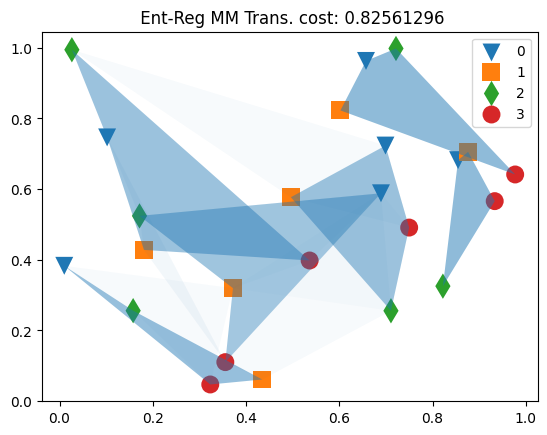

In [4]:
def plot_tensor(
    out: mmsinkhorn.MMSinkhornOutput,
    top_k: Optional[int] = None,
    title_str: str = "",
    highlight: int = -1,
):
    """display top_k largest transport in a tensor.

    Append ``title_str`` to title, highlights ``highlight`` index point cloud.
    """
    top_k = n_s[0] * 2 if top_k is None else top_k
    assert top_k < jnp.prod(
        jnp.array(n_s)
    ), "Intended number of tuples too large."
    # Extract top_k largest entries in the tensor, and their indices.
    val, idx = jax.lax.top_k(out.tensor.ravel(), top_k)
    indices = jnp.unravel_index(idx, n_s)
    # Setttings for plot
    markers = "vsdo"

    fig, ax = plt.subplots()
    for i in range(len(n_s)):
        ax.scatter(
            out.x_s[i][:, 0],
            out.x_s[i][:, 1],
            s=1000 * out.a_s[i],
            marker=markers[i],
            linewidth=2.0 if i == highlight else 0.0,
            edgecolor="k" if i == highlight else None,
            label=str(i),
        )

    for j in range(top_k):
        points = [out.x_s[i][indices[i][j], :] for i in range(len(n_s))]
        # reorder to ensure polygons have maximal area
        points = [points[i] for i in ccworder(jnp.array(points))]
        points = ptc.Polygon(
            points, fill=True, alpha=0.5 * float(val[j] * n_s[0])
        )
        ax.add_patch(points)
    ax.legend()
    plt.title(title_str + " Ent-Reg MM Trans. cost: " + str(out.ent_reg_cost))


plot_tensor(out)

## Gradient Flow

Suppose the points in ``x_s[0, :]`` stay put, and that all other 3 point clouds can be moved. To decrease their entropy-regularized MM transport cost, we can use gradient descent. Here, the {class}`~ott.experimental.mmsinkhorn.MMSinkhorn` solver uses by default the {cite}`danskin:67` theorem to facilitate the computation of the gradient of the entropy regularized cost, w.r.t. the point cloud locations.

In [5]:
def objective(x_s, a_s):
    out = mmsinkhorn.MMSinkhorn()(x_s=x_s, a_s=a_s, epsilon=1e-2)
    return out.ent_reg_cost, out


objective_v_g = jax.jit(jax.value_and_grad(objective, has_aux=True))

We run a fixed step size gradient descent loop. We display updated points, along with their gradients. The downward blue triangles are displayed with edges to illustrate that they are pinned.

Notice that the entropy regularized cost (displayed in the title of each plot) decreases, and becomes even negative. This is not unusual, since unlike the standard MMOT cost which is necessarily non-negative, this output is regularized with a negative entropy.

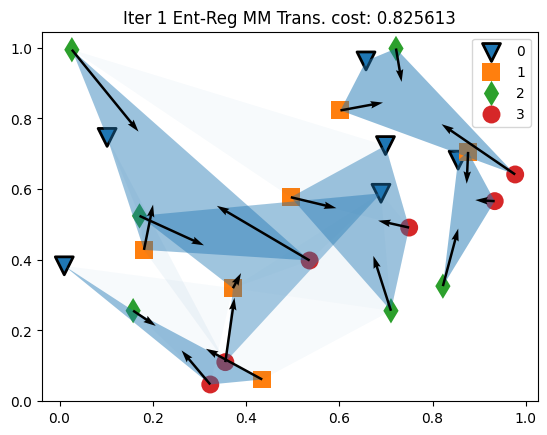

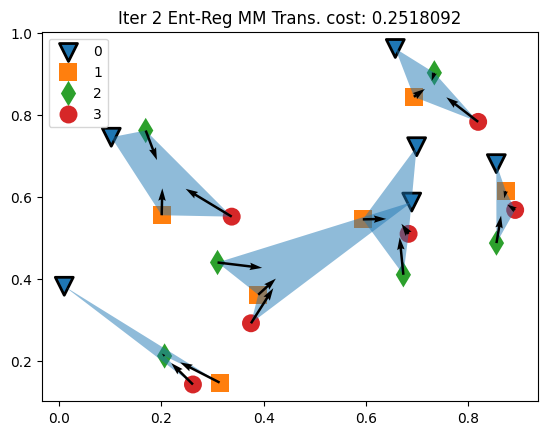

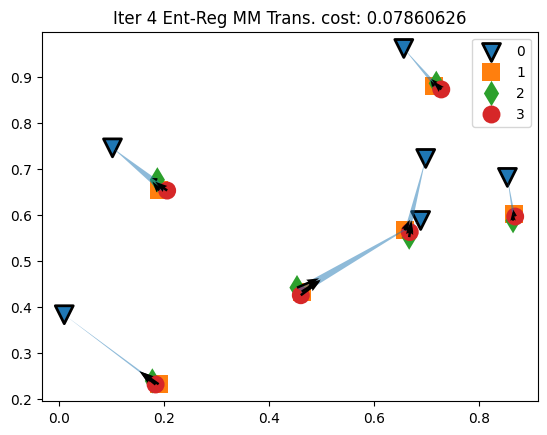

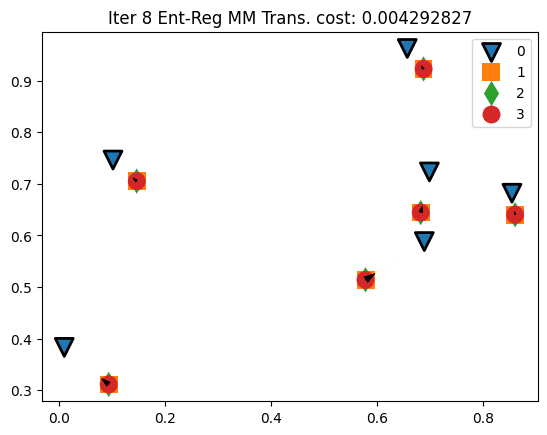

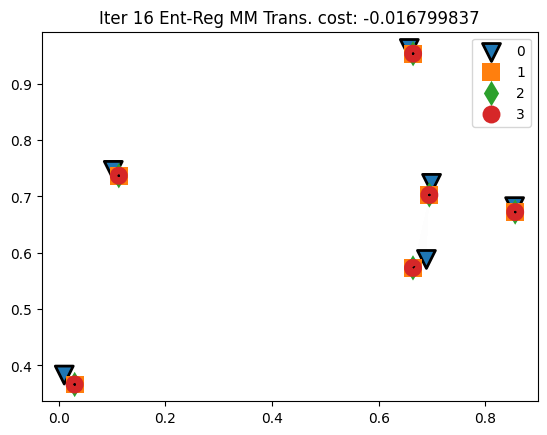

In [6]:
lr = 0.5
quiv_args = {"scale": 1, "angles": "xy", "scale_units": "xy", "width": 0.005}

x_s_t = x_s
for i in range(1, 17):
    (v, out), g_s = objective_v_g(x_s_t, a_s)
    # Plot points + gradients when iteration is a powers of 2
    if math.log2(i).is_integer():
        ax = plot_tensor(out, title_str=f"Iter {i}", highlight=0)
        for x, g in zip(x_s_t[1:], g_s[1:]):
            plt.quiver(
                x[:, 0],
                x[:, 1],
                -lr * g[:, 0],  # double to make gradient more visible
                -lr * g[:, 1],  # double to make gradient more visible
                **quiv_args,
            )

    x_s_t = [x_s[0]] + [x - lr * g for x, g in zip(x_s_t[1:], g_s[1:])]